# **Using Black's Model to Value Futures Options**

#### **Author: Zachary Wright, CFA, FRM | Last Updated: 02/27/25**

**Overview:** In this project, I use Options, Futures, and Other Derivatives by Hull (2022) as a reference to value futures options with Black's Model (also known as Black-76) in Python. Note that while certain libraries may streamline functionality, I am attempting to develop much of the functionality myself.

Black's Model is derived from:
1.   Itô’s Lemma, which is used to describe the stochastic process of the futures price
2.   A modified Black-Scholes Partial Differential Equation, where the dividend yield equals the risk-free rate, adjusting for the fact that futures have no cost of carry

A lognormal assumption is chosen here as a baseline to capture asset price behavior. Real market behavior may deviate from such an assumption, and deviations from the assumed distribution can create mispricings and arbitrage opportunities.

**Planned Updates:**
- Option class and methods - finish methods for calculation of the Greeks
- Sensitivity and scenario analysis
- Backtesting
- Metric visualizations
- Exploration of model limitations

**Latest Changes:**
* Added user input functionality to set variables with exception handling
* Started class and method definitions
* Started vizualizations for sensitivity analysis

**Libraries Used:**
- Numpy
- SciPy
- Matplotlib

---

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

Setting variables through user input:

In [ ]:
try:
  volatility = float(input("Enter volatility per annum: "))
  rfr = float(input("Enter the risk-free rate per annum: "))
  strike = float(input("Enter strike price: "))
  futures_price = float(input("Enter the futures price: "))
  time = float(input("Enter the time to contract expiration (fractions of a year): "))
  print("\nVariables set successfully.\n")
except ValueError:
  print("\n Values must be numbers and in decimal form.\n")

Enter volatility per annum: .25
Enter the risk-free rate per annum: .0433
Enter strike price: 20
Enter the futures price: 18
Enter the time to contract expiration (fractions of a year): .4

Variables set successfully.



Calculating `d1` and `d2`:

In [ ]:
d1 = ((np.log(futures_price / strike) + ((volatility**2) * (time/2))))/(volatility*np.sqrt(time))
d2 = ((np.log(futures_price / strike) - ((volatility**2) * (time/2))))/(volatility*np.sqrt(time))

print("d1: ",d1)
print("d2: ",d2)

d1:  -0.5873014683529201
d2:  -0.7454153513613391


In [ ]:
c = (np.exp(-rfr*time))*((futures_price*norm.cdf(d1)) - (strike*norm.cdf(d2)))
p = (np.exp(-rfr*time))*((strike*norm.cdf(-1*d2)) - (futures_price*norm.cdf(-1*d1)))

print("Options Price: \n", "Call: ", c, "\n", "Put: ", p , "\n")

Options Price: 
 Call:  0.44502958291812156 
 Put:  2.410687840892953 



Since this is functionality we may want to consider for multiple different futures options, I will create an Options class to get individual call and put option prices. We will be able to set volatility, strike price, futures price, risk-free rates, and time to expiration for each. I will also incorporate methods to get the Greeks of each `FuturesOption` object.

In [ ]:
class FuturesOption:
  def __init__(self,volatility,strike,futures_price,rfr,time):
    self.volatility = volatility
    self.strike = strike
    self.futures_price = futures_price
    self.rfr = rfr
    self.time = time

  def compute_d1_d2(self):
      self.d1 = (np.log(self.futures_price / self.strike) + (self.volatility**2 * self.time / 2)) / (self.volatility * np.sqrt(self.time))
      self.d2 = self.d1 - self.volatility * np.sqrt(self.time)

  def get_call_price(self):
    self.compute_d1_d2()
    return (np.exp(-self.rfr*self.time))*((self.futures_price*norm.cdf(self.d1)) - (self.strike*norm.cdf(self.d2)))

  def get_put_price(self):
    self.compute_d1_d2()
    return (np.exp(-self.rfr*self.time))*((self.strike*norm.cdf(-1*self.d2)) - (self.futures_price*norm.cdf(-1*self.d1)))

  def get_delta(self):
    return None

  def get_gamma(self):
    return None

  def get_rho(self):
    return None

  def get_theta(self):
    return None

  def get_vega(self):
    return None

  def update_vol(self, volatility):
    self.volatility = volatility
    self.compute_d1_d2()
    return self

  def update_time(self,time):
    self.time = time
    self.compute_d1_d2()
    return self
  def update_strike(self,strike):
    self.strike = strike
    self.compute_d1_d2()
    return self

We create an option object called `some_option` and call its methods at will, such as the call option price below:

In [ ]:
some_option = FuturesOption(volatility,strike,futures_price,rfr,time)
some_option.get_call_price()

0.44502958291812156

I run a quick volatility sensitivity vizualization on the `some_option` object below:

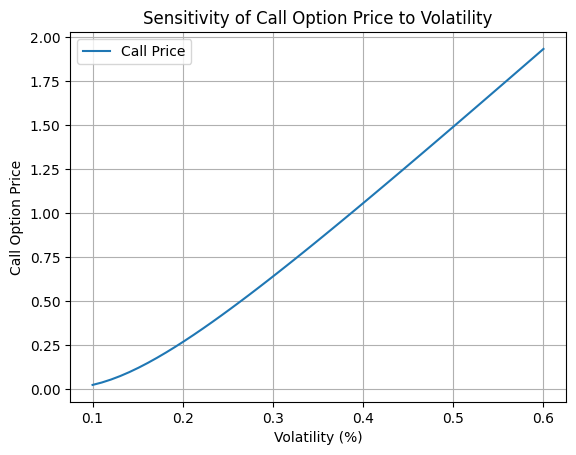

In [ ]:
vol_range = np.linspace(0.1, 0.6, 50)
call_prices = [some_option.update_vol(v).get_call_price() for v in vol_range]
plt.plot(vol_range, call_prices, label="Call Price")
plt.xlabel("Volatility (%)")
plt.ylabel("Call Option Price")
plt.title("Sensitivity of Call Option Price to Volatility")
plt.legend()
plt.grid(True)
plt.show()

I also incorporate a way to view the the call option price sensitivity for different values of the strike price.

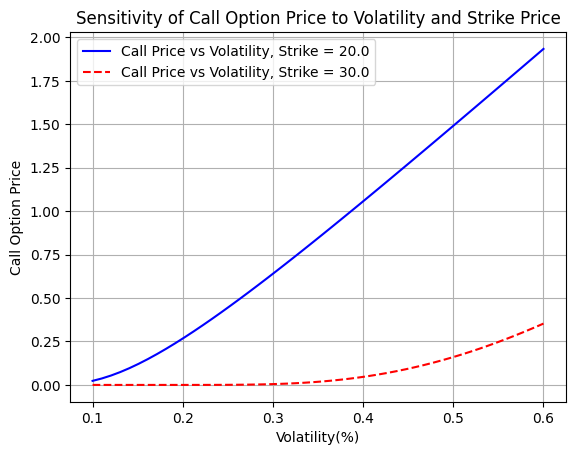

In [ ]:
initial_strike = strike
vol_range = np.linspace(0.1, 0.6, 50)
vol_call_prices1 = [some_option.update_vol(v).get_call_price() for v in vol_range]
new_strike = float(30)
some_option.update_strike(new_strike)
vol_call_prices2 = [some_option.update_vol(v).get_call_price() for v in vol_range]

plt.plot(vol_range, vol_call_prices1, label=f"Call Price vs Volatility, Strike = {initial_strike}", color="b", linestyle="-")
plt.plot(vol_range, vol_call_prices2, label=f"Call Price vs Volatility, Strike = {new_strike}", color="r", linestyle="--")
plt.xlabel("Volatility(%)")
plt.ylabel("Call Option Price")
plt.title("Sensitivity of Call Option Price to Volatility and Strike Price")
plt.legend()
plt.grid(True)
plt.show()

As expected, we see a more profound call option price sensitivity to volatility for the strike price that is closer to being at-the-money.